In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from sklearn.metrics import(confusion_matrix, precision_score, recall_score, accuracy_score, f1_score)

[nltk_data] Downloading package stopwords to /Users/caleb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/caleb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/caleb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/caleb/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/caleb/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Loading the Datasets
#Original DataFrame
df = pd.read_csv("tweets.csv")
#Initial tweets
init = pd.read_csv("text_only.csv")
init.rename(columns = {"Unnamed: 0": "index"}, inplace=True)
#Tweets that does not contain stopwords
tweets = pd.read_csv("tweets_without_stopwords.csv")
tweets.rename(columns = {"Unnamed: 0": "index"}, inplace=True)
#Drop the unnecessary column
tweets.drop('index', inplace=True, axis=1)

In [3]:
#Adding the tweet created time and converted it into usable type
tweets["created_at"] = df["created_at"]
tweets['created_at'] = pd.to_datetime(tweets.created_at)
#tweets['created_at'] = tweets['created_at'].dt.strftime('%m/%d/%Y')
tweets['created_at'] = pd.to_datetime(tweets["created_at"].dt.strftime('%m/%d/%Y'))
tweets['year'] = pd.DatetimeIndex(tweets['created_at']).year

#Adding the original tweets
tweets["original"] = df["text"]


#Reorder the Column and Row
tweets = tweets[["year", "created_at", "original", "edited", "tweet_without_stopwords"]]
tweets = tweets.sort_values(by='created_at')

#Tokenize the tweets
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')
tweets['text_token']=tweets['tweet_without_stopwords'].apply(regexp.tokenize)

tweets

year created_at                                           original  \
34802  2017 2017-01-01  Phoenix volvo fee: changing your natural gas: ...   
5568   2017 2017-01-02  FORCE MOTORS LTD.-$ - 500033 - Resumption of p...   
5567   2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   
5566   2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   
22295  2017 2017-01-02  Mercedes Benz Style Kids Ride on Battery Power...   
...     ...        ...                                                ...   
28505  2022 2022-08-31  Volvo's campaign promotes its range of Recharg...   
28504  2022 2022-08-31  Volvo Trucks North America declared the end of...   
28503  2022 2022-08-31  @Domenick_Y @switchEVglobal https://t.co/EOJPN...   
28506  2022 2022-08-31  One of the added complexities of modern life a...   
14914  2022 2022-08-31  @oilcata @jonandrelokke @BMW @nelhydrogen @H2E...   

                                                  edited  \
34802  phoenix volvo fee  changing your natural gas  ...   
5568   force motors ltd      500033   resumption of p...   
5567   force motors ltd  resumption of production act...   
5566   force motors ltd  resumption of production act...   
22295  mercedes benz style kids ride on battery power...   
...                                                  ...   
28505  volvo s campaign promotes its range of recharg...   
28504  volvo trucks north america declared the end of...   
28503      this is my go to   the accumulated emissio...   
28506  one of the added complexities of modern life a...   
14914         mercedes benz cancelled the h2 developm...   

                                 tweet_without_stopwords  \
34802        phoenix volvo fee changing natural gas kev    
5568   force motors ltd 500033 resumption production ...   
5567    force motors ltd resumption production activity    
5566    force motors ltd resumption production activity    
22295  mercedes benz style kids ride battery powered ...   
...                                                  ...   
28505  volvo campaign promotes range recharge electri...   
28504  volvo trucks north america declared end innova...   
28503   go accumulated emissions materials production...   
28506  one added complexities modern life forever con...   
14914   mercedes benz cancelled h2 development severa...   

                                              text_token  
34802  [phoenix, volvo, fee, changing, natural, gas, ...  
5568   [force, motors, ltd, 500033, resumption, produ...  
5567   [force, motors, ltd, resumption, production, a...  
5566   [force, motors, ltd, resumption, production, a...  
22295  [mercedes, benz, style, kids, ride, battery, p...  
...                                                  ...  
28505  [volvo, campaign, promotes, range, recharge, e...  
28504  [volvo, trucks, north, america, declared, end,...  
28503  [go, accumulated, emissions, materials, produc...  
28506  [one, added, complexities, modern, life, forev...  
14914  [mercedes, benz, cancelled, h2, development, s...  

[47120 rows x 6 columns]

In [4]:
#Remove infrequent words
#The words that is less than 2 characters
tweets['text_string'] = tweets['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [5]:
#Create a list of all words
all_words = ' '.join([word for word in tweets['text_string']])

In [6]:
from nltk.probability import FreqDist
tokenized_words = nltk.tokenize.word_tokenize(all_words)

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'electric': 26514, 'battery': 24864, 'fuel': 13324, 'hydrogen': 10396, 'cell': 9658, 'mercedes': 7300, 'car': 6528, 'volvo': 6498, 'new': 6485, 'daimler': 6253, ...})

In [7]:
#Filtering out the words that less than 3 times.
tweets['text_string_fdist'] = tweets['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 3 ]))

#fit = ["battery electric", "li-ion", "lithium-ion", "Hydrogen Fuel Cell", "fuel cell", "hydrogen combusion engine", "hydrogen ICE", "natural gas", "compressed natural gas"]
fit = ["electric", "battery", "fuel", "cell", "cars", "vehicle", "new", "cells"]
tweets['text_string_excluded'] = tweets['text_token'].apply(lambda x: ' '.join([item for item in x if item not in fit]))



#tweets['text_string_fdist']
#tweets['text_string_excluded']



In [8]:
#Performing Lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()
tweets['text_string_lem'] = tweets['text_string_fdist'].apply(wordnet_lem.lemmatize)
tweets["tmp_lem"] = tweets['text_string_excluded'].apply(wordnet_lem.lemmatize)

#Check if the columsn are equal
tweets['is_equal']= (tweets['text_string_fdist']==tweets['text_string_lem'])
tweets.is_equal.value_counts()
#Since the amount of different rows is only 10, so we could just ignore it.

True     47110
False       10
Name: is_equal, dtype: int64

In [9]:
all_words_lem = ' '.join([word for word in tweets['text_string_lem']])
tmp_lem = ' '.join([word for word in tweets['tmp_lem']])

(-0.5, 599.5, 399.5, -0.5)

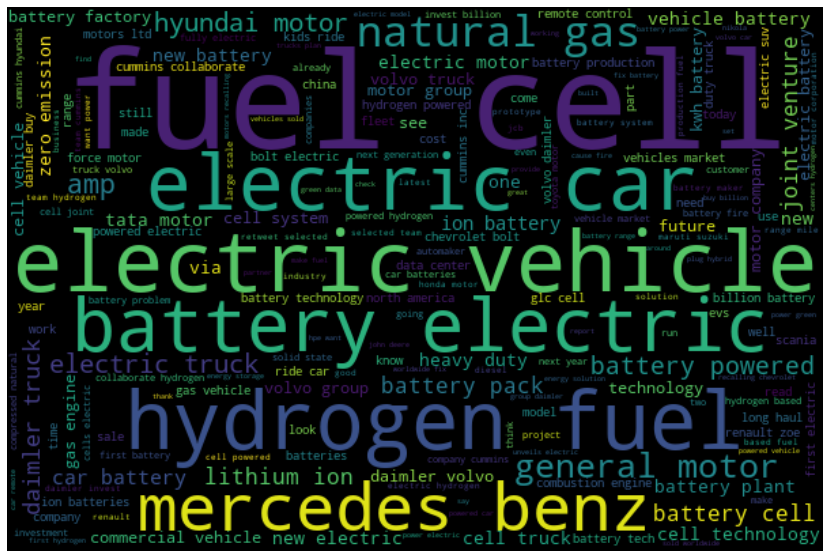

In [10]:
#Original Version
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

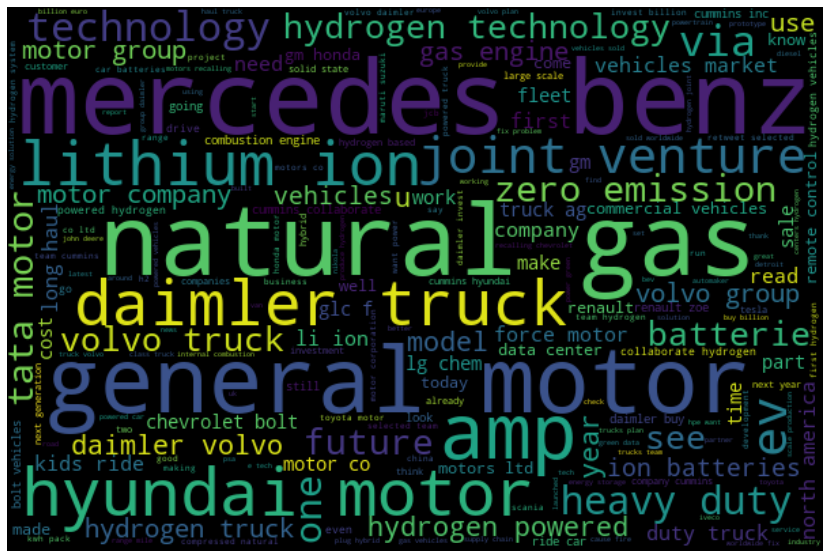

In [11]:
#Edited Version
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(tmp_lem)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [12]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
words = nltk.word_tokenize(all_words_lem)
edited_words = nltk.word_tokenize(tmp_lem)
fd = FreqDist(words)
edited_fd = FreqDist(edited_words)

In [13]:
# Obtain top 10 words
top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

In [14]:
fig = px.bar(y=fdist.index, x=fdist.values, title = "Top 10 Words Frequency Distribution",
             labels={
                 "x": "Frequency",
                 "y": "Word"}
            )

# sort values
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.update_layout(title_text='Top 10 Words Frequency Distribution', title_x=0.5)
# show plot
fig.show()

In [15]:
# Obtain top 10 words (edited_version)
top_10 = edited_fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

fig = px.bar(y=fdist.index, x=fdist.values, title = "Top 10 Words Frequency Distribution",
             labels={
                 "x": "Frequency",
                 "y": "Word"}
            )

# sort values
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.update_layout(title_text='Top 10 Words Frequency Distribution', title_x=0.5)

# show plot
fig.show()

In [16]:
def generate_word_cloud(text):
    fit = ["electric", "battery", "fuel", "cell", "cells", "car", "cars", "vehicle", "vehicles", "new"]
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        stopwords = fit,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [17]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
all_words = ' '.join([word for word in tweets['text_string_fdist']])
bigrams_series = (pd.Series(nltk.ngrams(basic_clean(all_words), 2)).value_counts())[:20]
bigrams_series

(fuel, cell)           12514
(electric, vehicle)     6631
(hydrogen, fuel)        6057
(electric, car)         5488
(battery, electric)     5304
(mercedes, benz)        4223
(natural, gas)          3969
(general, motor)        3367
(hyundai, motor)        1910
(electric, truck)       1899
(battery, powered)      1777
(car, battery)          1691
(daimler, truck)        1651
(ion, battery)          1620
(lithium, ion)          1553
(joint, venture)        1477
(battery, cell)         1448
(battery, pack)         1385
(vehicle, battery)      1209
(electric, motor)       1010
dtype: int64

Text(0.5, 0, '# of Occurances')

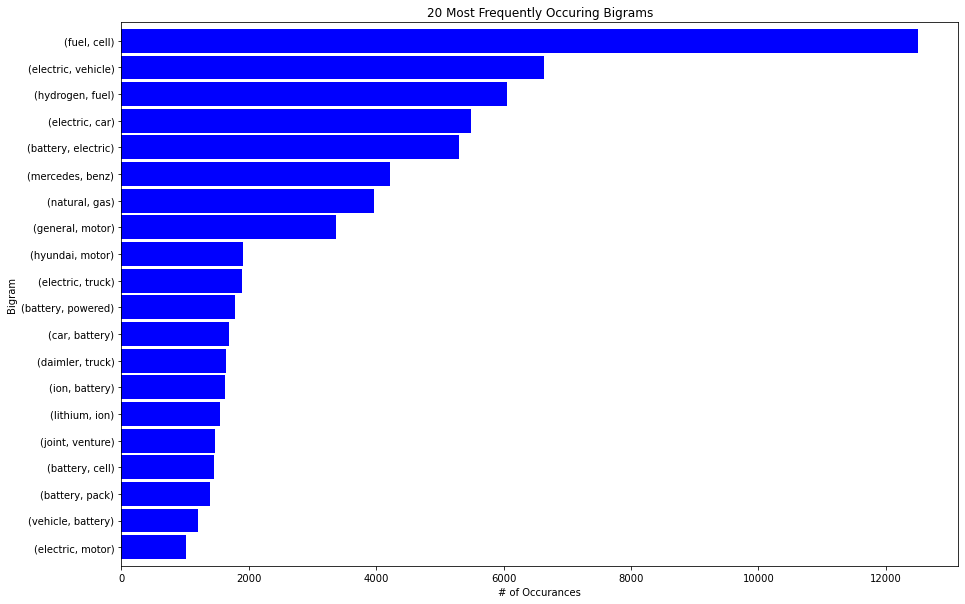

In [19]:
plt.figure(figsize=(15, 10))
bigrams_series.sort_values().plot.barh(color='blue', width=.9)
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [20]:
trigrams_series = (pd.Series(nltk.ngrams(basic_clean(all_words), 3)).value_counts())[:20]
trigrams_series

(hydrogen, fuel, cell)          5916
(battery, electric, vehicle)    1485
(electric, car, battery)        1458
(lithium, ion, battery)         1275
(electric, vehicle, battery)    1127
(fuel, cell, truck)              973
(fuel, cell, technology)         841
(fuel, cell, electric)           688
(battery, electric, truck)       665
(fuel, cell, vehicle)            634
(fuel, cell, system)             603
(natural, gas, engine)           545
(hyundai, motor, group)          544
(hyundai, motor, company)        508
(fuel, cell, powered)            426
(natural, gas, vehicle)          409
(bolt, electric, vehicle)        385
(force, motor, ltd)              360
(chevrolet, bolt, electric)      353
(fuel, cell, bus)                338
dtype: int64

Text(0.5, 0, '# of Occurances')

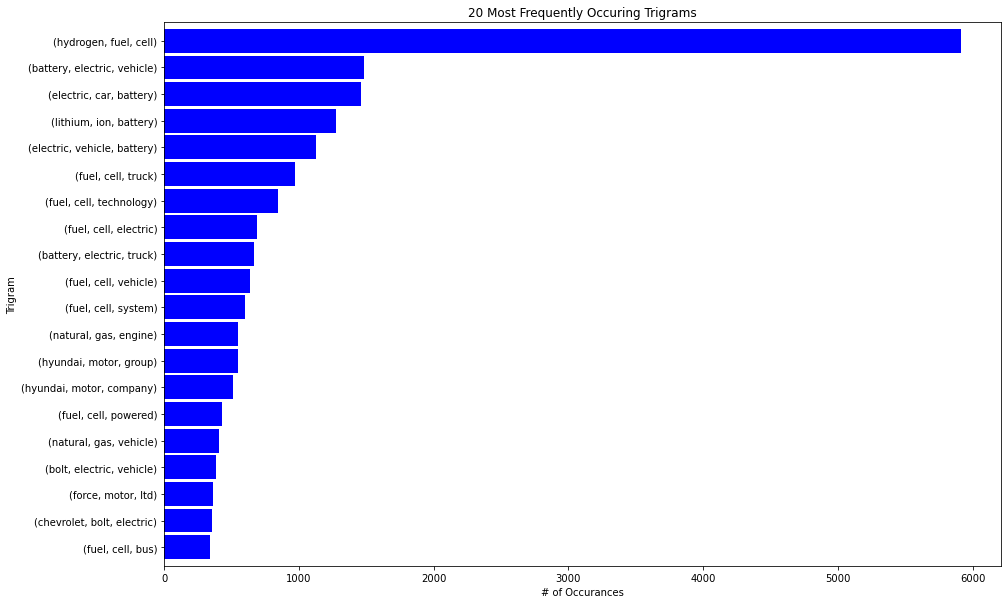

In [21]:
plt.figure(figsize=(15, 10))
trigrams_series.sort_values().plot.barh(color='blue', width=.9)
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [23]:
tweets['polarity'] = tweets['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
tweets.tail(3)

year created_at                                           original  \
28503  2022 2022-08-31  @Domenick_Y @switchEVglobal https://t.co/EOJPN...   
28506  2022 2022-08-31  One of the added complexities of modern life a...   
14914  2022 2022-08-31  @oilcata @jonandrelokke @BMW @nelhydrogen @H2E...   

                                                  edited  \
28503      this is my go to   the accumulated emissio...   
28506  one of the added complexities of modern life a...   
14914         mercedes benz cancelled the h2 developm...   

                                 tweet_without_stopwords  \
28503   go accumulated emissions materials production...   
28506  one added complexities modern life forever con...   
14914   mercedes benz cancelled h2 development severa...   

                                              text_token  \
28503  [go, accumulated, emissions, materials, produc...   
28506  [one, added, complexities, modern, life, forev...   
14914  [mercedes, benz, cancelled, h2, development, s...   

                                             text_string  \
28503  accumulated emissions materials production ref...   
28506  one added complexities modern life forever con...   
14914  mercedes benz cancelled development several ye...   

                                       text_string_fdist  \
28503  accumulated emissions materials production ref...   
28506  one added modern life forever connected retain...   
14914  mercedes benz cancelled development several ye...   

                                    text_string_excluded  \
28503  go accumulated emissions materials production ...   
28506  one added complexities modern life forever con...   
14914  mercedes benz cancelled h2 development several...   

                                         text_string_lem  \
28503  accumulated emissions materials production ref...   
28506  one added modern life forever connected retain...   
14914  mercedes benz cancelled development several ye...   

                                                 tmp_lem  is_equal  \
28503  go accumulated emissions materials production ...      True   
28506  one added complexities modern life forever con...      True   
14914  mercedes benz cancelled h2 development several...      True   

                                                polarity  
28503  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
28506  {'neg': 0.06, 'neu': 0.851, 'pos': 0.089, 'com...  
14914  {'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...

In [24]:
# Change data structure
tweets = pd.concat(
    [tweets.drop(['polarity'], axis=1), 
     tweets['polarity'].apply(pd.Series)], axis=1)
tweets.head(3)

year created_at                                           original  \
34802  2017 2017-01-01  Phoenix volvo fee: changing your natural gas: ...   
5568   2017 2017-01-02  FORCE MOTORS LTD.-$ - 500033 - Resumption of p...   
5567   2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   

                                                  edited  \
34802  phoenix volvo fee  changing your natural gas  ...   
5568   force motors ltd      500033   resumption of p...   
5567   force motors ltd  resumption of production act...   

                                 tweet_without_stopwords  \
34802        phoenix volvo fee changing natural gas kev    
5568   force motors ltd 500033 resumption production ...   
5567    force motors ltd resumption production activity    

                                              text_token  \
34802  [phoenix, volvo, fee, changing, natural, gas, ...   
5568   [force, motors, ltd, 500033, resumption, produ...   
5567   [force, motors, ltd, resumption, production, a...   

                                             text_string  \
34802         phoenix volvo fee changing natural gas kev   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   

                                       text_string_fdist  \
34802             phoenix volvo fee changing natural gas   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   

                                    text_string_excluded  \
34802         phoenix volvo fee changing natural gas kev   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   

                                         text_string_lem  \
34802             phoenix volvo fee changing natural gas   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   

                                                 tmp_lem  is_equal  neg  \
34802         phoenix volvo fee changing natural gas kev      True  0.0   
5568   force motors ltd 500033 resumption production ...      True  0.0   
5567     force motors ltd resumption production activity      True  0.0   

         neu    pos  compound  
34802  0.667  0.333    0.3612  
5568   1.000  0.000    0.0000  
5567   1.000  0.000    0.0000

In [25]:
# Create new variable with sentiment "neutral," "positive" and "negative"
tweets['sentiment'] = tweets['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
tweets.head(4)

year created_at                                           original  \
34802  2017 2017-01-01  Phoenix volvo fee: changing your natural gas: ...   
5568   2017 2017-01-02  FORCE MOTORS LTD.-$ - 500033 - Resumption of p...   
5567   2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   
5566   2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   

                                                  edited  \
34802  phoenix volvo fee  changing your natural gas  ...   
5568   force motors ltd      500033   resumption of p...   
5567   force motors ltd  resumption of production act...   
5566   force motors ltd  resumption of production act...   

                                 tweet_without_stopwords  \
34802        phoenix volvo fee changing natural gas kev    
5568   force motors ltd 500033 resumption production ...   
5567    force motors ltd resumption production activity    
5566    force motors ltd resumption production activity    

                                              text_token  \
34802  [phoenix, volvo, fee, changing, natural, gas, ...   
5568   [force, motors, ltd, 500033, resumption, produ...   
5567   [force, motors, ltd, resumption, production, a...   
5566   [force, motors, ltd, resumption, production, a...   

                                             text_string  \
34802         phoenix volvo fee changing natural gas kev   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   
5566     force motors ltd resumption production activity   

                                       text_string_fdist  \
34802             phoenix volvo fee changing natural gas   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   
5566     force motors ltd resumption production activity   

                                    text_string_excluded  \
34802         phoenix volvo fee changing natural gas kev   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   
5566     force motors ltd resumption production activity   

                                         text_string_lem  \
34802             phoenix volvo fee changing natural gas   
5568   force motors ltd 500033 resumption production ...   
5567     force motors ltd resumption production activity   
5566     force motors ltd resumption production activity   

                                                 tmp_lem  is_equal  neg  \
34802         phoenix volvo fee changing natural gas kev      True  0.0   
5568   force motors ltd 500033 resumption production ...      True  0.0   
5567     force motors ltd resumption production activity      True  0.0   
5566     force motors ltd resumption production activity      True  0.0   

         neu    pos  compound sentiment  
34802  0.667  0.333    0.3612  positive  
5568   1.000  0.000    0.0000   neutral  
5567   1.000  0.000    0.0000   neutral  
5566   1.000  0.000    0.0000   neutral

In [26]:
# Number of tweets
tmp_1 = tweets.groupby("sentiment").size()
fig = px.bar(data_frame = tmp_1, title = "The Overall Sentiment Distribution",
             labels={
                 "x": "Sentiment",
                 "y": "Count"},
            text=tmp_1)
fig.update_layout(showlegend=False)
fig.update_layout(title_text='The Overall Sentiment Distribution', title_x=0.5)

fig.show()

Text(0, 0.5, '')

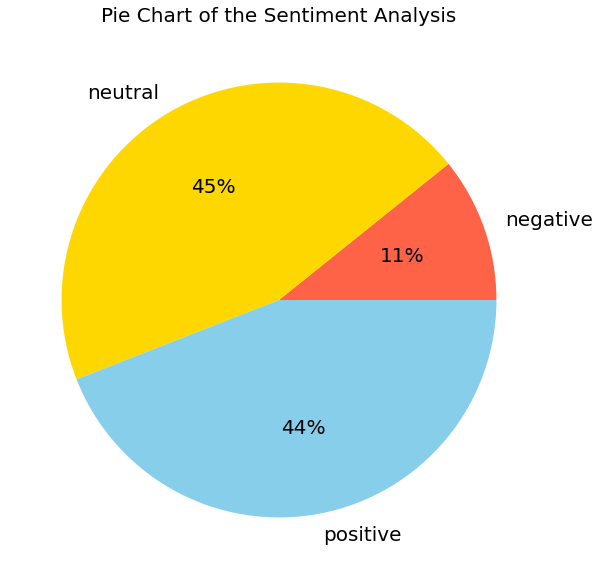

In [27]:
plt.figure(figsize=(15,10))

tweets.groupby('sentiment').size().plot(kind='pie', autopct='%1.0f%%', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])

plt.title("Pie Chart of the Sentiment Analysis", fontsize=20)
plt.xlabel("")
plt.ylabel("")

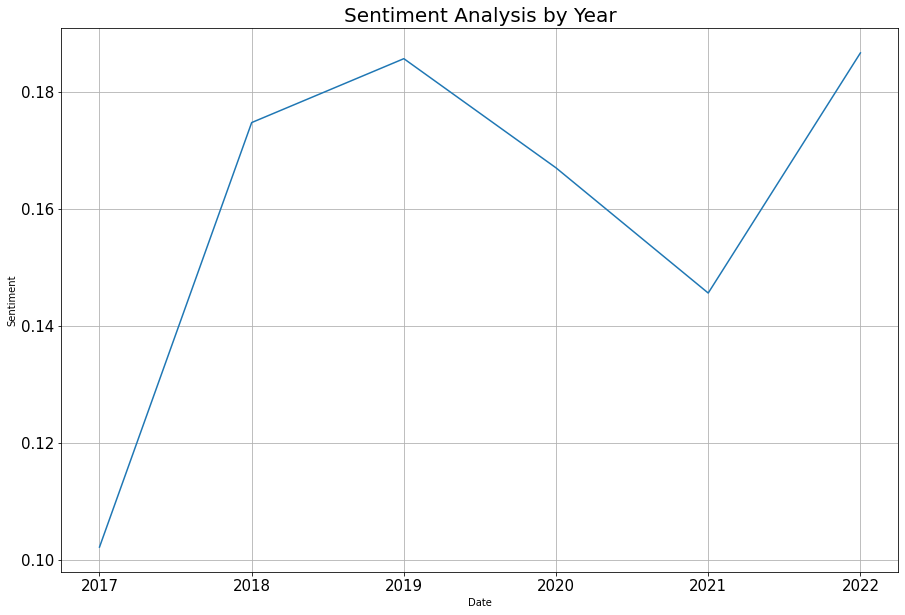

In [28]:
# Lineplot
plt.figure(figsize=(15,10))

plt.plot(tweets.groupby(['year'])['compound'].mean())

plt.title("Sentiment Analysis by Year", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

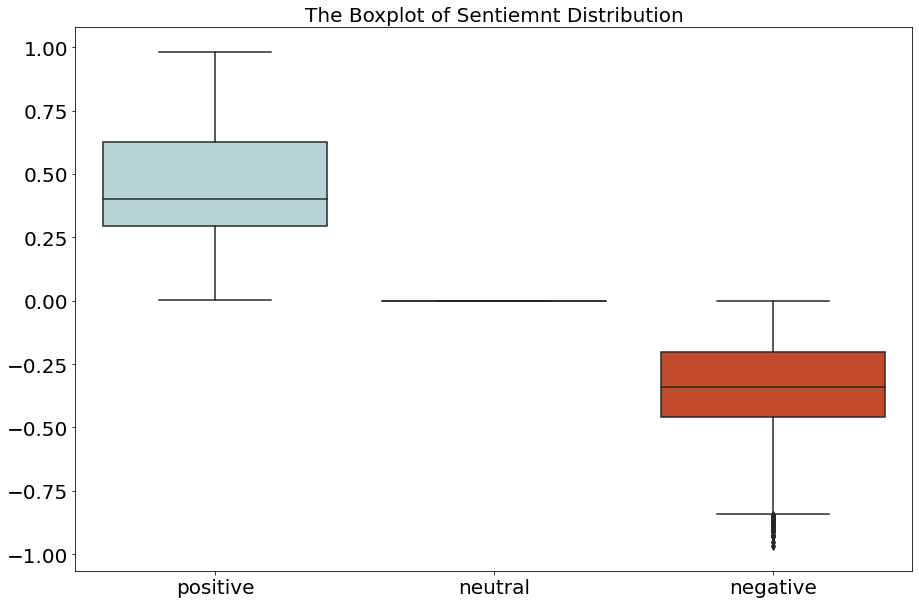

In [29]:
# Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=tweets)

plt.title("The Boxplot of Sentiemnt Distribution", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [30]:
#looking the outlier
x = tweets.groupby('sentiment')['compound']
x = x.get_group("negative")

Q1 = np.quantile(x, q = 0.25)
Q3 = np.quantile(x, q = 0.75)
    
IQR = Q3 - Q1

lower_whisker = Q1-1.5*IQR
lower_whisker

tmp = tweets[tweets['compound']<-0.84]
tmp.to_csv("tmp.csv")

In [31]:
tweets.reset_index(drop=True,inplace=True)

In [32]:
tweets[tweets["created_at"] <= '2020-12-31 23:59:59']

print("The Train data set is: ",28328 / 47120, "% of the data.")

The Train data set is:  0.6011884550084889 % of the data.


In [33]:
#Bag of Words Approach
#X_input
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000)
x_fin = cv.fit_transform(tweets['text_string_fdist']).toarray()

#Y_input
y = tweets['sentiment']
sentiment_ordering = ['negative', 'neutral', 'positive']
y = y.apply(lambda x: sentiment_ordering.index(x))

### naive bayes (MultionmialNB)

In [34]:
from sklearn.naive_bayes import MultinomialNB
bayes_model = MultinomialNB()

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_fin, y, train_size=0.6, shuffle=False)
bayes_model.fit(x_train, y_train)

MultinomialNB()

In [36]:
y_pred = bayes_model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55      2358
           1       0.84      0.77      0.81      7903
           2       0.79      0.80      0.80      8587

    accuracy                           0.77     18848
   macro avg       0.71      0.73      0.72     18848
weighted avg       0.78      0.77      0.77     18848



In [37]:
print("accuracy", accuracy_score(y_test,y_pred))
score = f1_score(y_test, y_pred, average='micro')
print('F-1 score : {}'.format(np.round(score,4)))

accuracy 0.7654923599320883
F-1 score : 0.7655


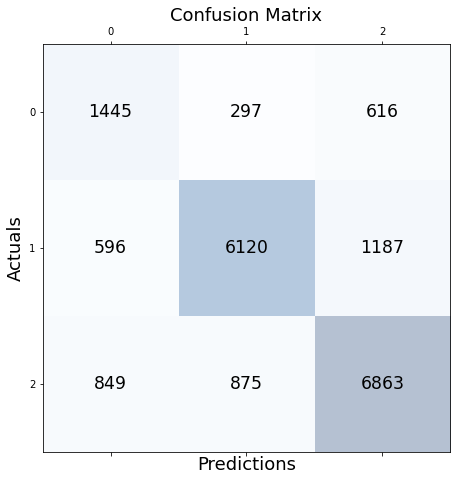

In [38]:
#Graph
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [39]:
#Convert it into Data Frame
pd.DataFrame(confusion_matrix(y_test,y_pred), index=["Negative", "Neutral", "Positive"], columns = ["Negative", "Neutral", "Positive"])


Negative  Neutral  Positive
Negative      1445      297       616
Neutral        596     6120      1187
Positive       849      875      6863

In [40]:
# n-grams approach
# train model with different n-gram ranges
# establish input and output
X = list(tweets['text_string_fdist'])
y = list(tweets['sentiment'])

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=False)


cv = CountVectorizer(analyzer = 'word',ngram_range=(1,2))

# convert training data to bag of words
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)



# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
score = f1_score(y_test, y_pred, average='micro')
print('F-1 score : {}'.format(np.round(score,4)))

F-1 score : 0.7454


In [41]:
for N in range(1,11):
    
    # convert training data to bag of words
    cv = CountVectorizer(analyzer = 'word',ngram_range=(1,N), stop_words='english')
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    
    # train model and generate predictions
    clf = MultinomialNB()
    clf.fit(X_train_cv, y_train)
    y_pred = clf.predict(X_test_cv)
    
    # compute f-1 score
    score = np.round(f1_score(y_test, y_pred, average='micro'),4)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N), score))

F-1 score of model with n-gram range of (1, 1): 0.778
F-1 score of model with n-gram range of (1, 2): 0.7416
F-1 score of model with n-gram range of (1, 3): 0.7129
F-1 score of model with n-gram range of (1, 4): 0.7053
F-1 score of model with n-gram range of (1, 5): 0.7047
F-1 score of model with n-gram range of (1, 6): 0.7033
F-1 score of model with n-gram range of (1, 7): 0.7024
F-1 score of model with n-gram range of (1, 8): 0.7021
F-1 score of model with n-gram range of (1, 9): 0.7009
F-1 score of model with n-gram range of (1, 10): 0.6991


In [42]:
tweets

year created_at                                           original  \
0      2017 2017-01-01  Phoenix volvo fee: changing your natural gas: ...   
1      2017 2017-01-02  FORCE MOTORS LTD.-$ - 500033 - Resumption of p...   
2      2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   
3      2017 2017-01-02  FORCE MOTORS LTD. Resumption of production act...   
4      2017 2017-01-02  Mercedes Benz Style Kids Ride on Battery Power...   
...     ...        ...                                                ...   
47115  2022 2022-08-31  Volvo's campaign promotes its range of Recharg...   
47116  2022 2022-08-31  Volvo Trucks North America declared the end of...   
47117  2022 2022-08-31  @Domenick_Y @switchEVglobal https://t.co/EOJPN...   
47118  2022 2022-08-31  One of the added complexities of modern life a...   
47119  2022 2022-08-31  @oilcata @jonandrelokke @BMW @nelhydrogen @H2E...   

                                                  edited  \
0      phoenix volvo fee  changing your natural gas  ...   
1      force motors ltd      500033   resumption of p...   
2      force motors ltd  resumption of production act...   
3      force motors ltd  resumption of production act...   
4      mercedes benz style kids ride on battery power...   
...                                                  ...   
47115  volvo s campaign promotes its range of recharg...   
47116  volvo trucks north america declared the end of...   
47117      this is my go to   the accumulated emissio...   
47118  one of the added complexities of modern life a...   
47119         mercedes benz cancelled the h2 developm...   

                                 tweet_without_stopwords  \
0            phoenix volvo fee changing natural gas kev    
1      force motors ltd 500033 resumption production ...   
2       force motors ltd resumption production activity    
3       force motors ltd resumption production activity    
4      mercedes benz style kids ride battery powered ...   
...                                                  ...   
47115  volvo campaign promotes range recharge electri...   
47116  volvo trucks north america declared end innova...   
47117   go accumulated emissions materials production...   
47118  one added complexities modern life forever con...   
47119   mercedes benz cancelled h2 development severa...   

                                              text_token  \
0      [phoenix, volvo, fee, changing, natural, gas, ...   
1      [force, motors, ltd, 500033, resumption, produ...   
2      [force, motors, ltd, resumption, production, a...   
3      [force, motors, ltd, resumption, production, a...   
4      [mercedes, benz, style, kids, ride, battery, p...   
...                                                  ...   
47115  [volvo, campaign, promotes, range, recharge, e...   
47116  [volvo, trucks, north, america, declared, end,...   
47117  [go, accumulated, emissions, materials, produc...   
47118  [one, added, complexities, modern, life, forev...   
47119  [mercedes, benz, cancelled, h2, development, s...   

                                             text_string  \
0             phoenix volvo fee changing natural gas kev   
1      force motors ltd 500033 resumption production ...   
2        force motors ltd resumption production activity   
3        force motors ltd resumption production activity   
4      mercedes benz style kids ride battery powered ...   
...                                                  ...   
47115  volvo campaign promotes range recharge electri...   
47116  volvo trucks north america declared end innova...   
47117  accumulated emissions materials production ref...   
47118  one added complexities modern life forever con...   
47119  mercedes benz cancelled development several ye...   

                                       text_string_fdist  \
0                 phoenix volvo fee changing natural gas   
1      force motors ltd 500033 resumption production ...   
2        force mot

### Clustering & Classification

In [43]:
#Subseting the dataset
electric = tweets[tweets["text_string_fdist"].str.contains('electric|battery electric|lithium-ion|lithium', case=False, regex=True)]
hydrogen = tweets[tweets["text_string_fdist"].str.contains('hydrogen|hydrogen fuel|hydrogen|h2 ice', case=False, regex=True)]
hydrogen_engine = tweets[tweets["text_string_fdist"].str.contains('hydrogen engine|hydrogen combusion engine', case=False, regex=True)]
natural_gas = tweets[tweets["text_string_fdist"].str.contains('natural gas|cng', case=False, regex=True)]



#### electric

Text(0, 0.5, '')

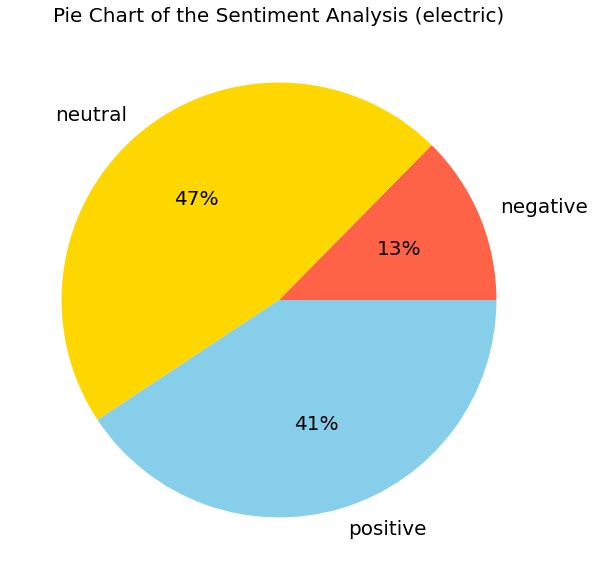

In [44]:
plt.figure(figsize=(15,10))

electric.groupby('sentiment').size().plot(kind='pie', autopct='%1.0f%%', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])

plt.title("Pie Chart of the Sentiment Analysis (electric)", fontsize=20)
plt.xlabel("")
plt.ylabel("")

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

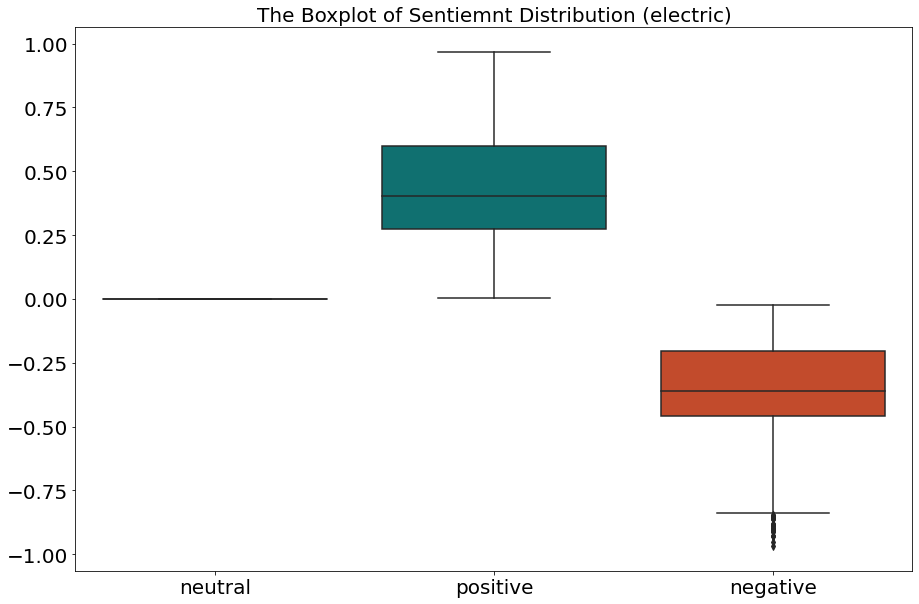

In [45]:
# Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=electric)

plt.title("The Boxplot of Sentiemnt Distribution (electric)", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

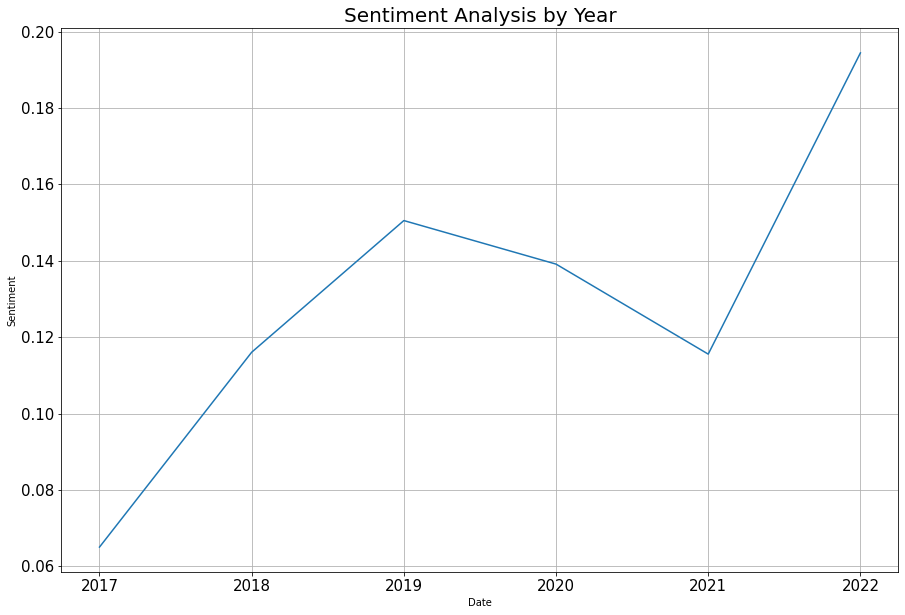

In [46]:
# Lineplot
plt.figure(figsize=(15,10))

plt.plot(electric.groupby(['year'])['compound'].mean())

plt.title("Sentiment Analysis by Year", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

#### hydrogen

Text(0, 0.5, '')

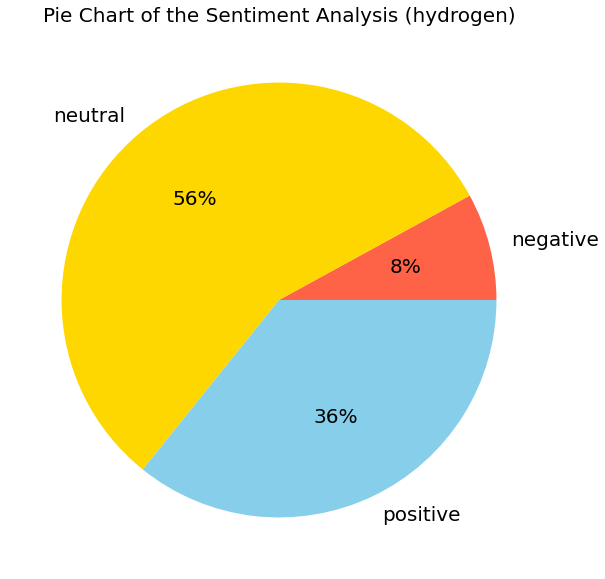

In [47]:
plt.figure(figsize=(15,10))

hydrogen.groupby('sentiment').size().plot(kind='pie', autopct='%1.0f%%', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])

plt.title("Pie Chart of the Sentiment Analysis (hydrogen)", fontsize=20)
plt.xlabel("")
plt.ylabel("")

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

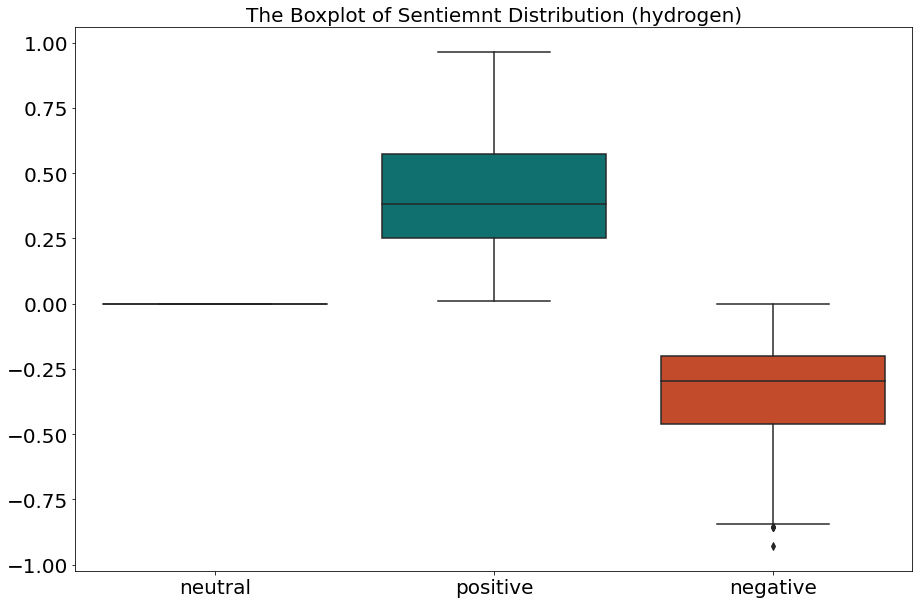

In [48]:
# Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=hydrogen)

plt.title("The Boxplot of Sentiemnt Distribution (hydrogen)", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

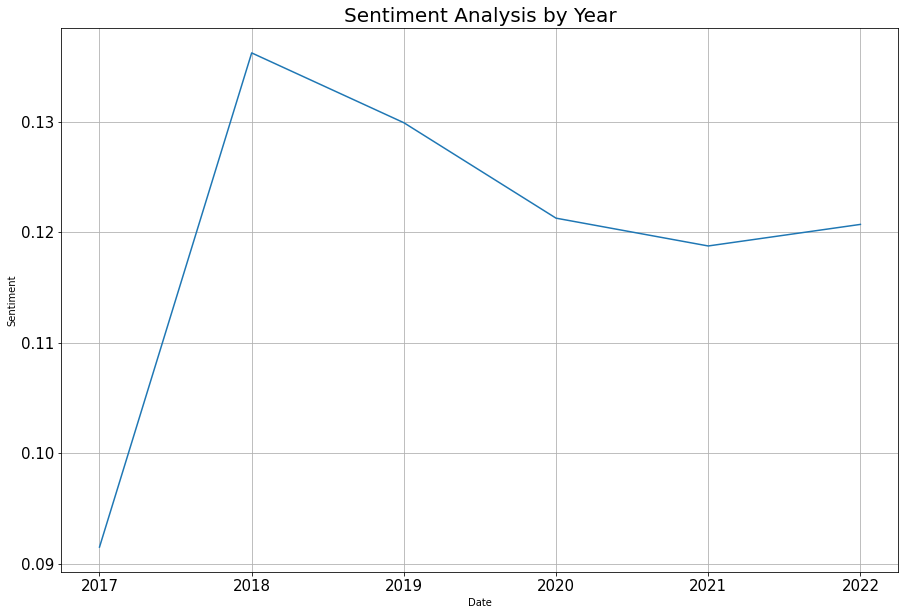

In [49]:
# Lineplot
plt.figure(figsize=(15,10))

plt.plot(hydrogen.groupby(['year'])['compound'].mean())

plt.title("Sentiment Analysis by Year", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

#### hydrogen engine

Text(0, 0.5, '')

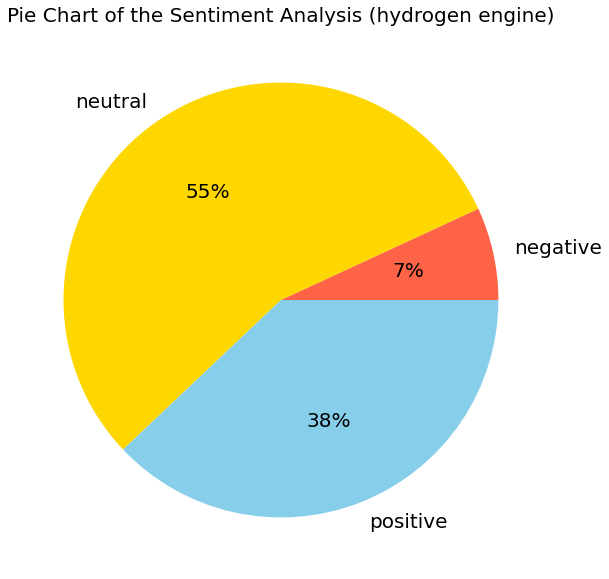

In [50]:
plt.figure(figsize=(15,10))

hydrogen_engine.groupby('sentiment').size().plot(kind='pie', autopct='%1.0f%%', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])

plt.title("Pie Chart of the Sentiment Analysis (hydrogen engine)", fontsize=20)
plt.xlabel("")
plt.ylabel("")

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

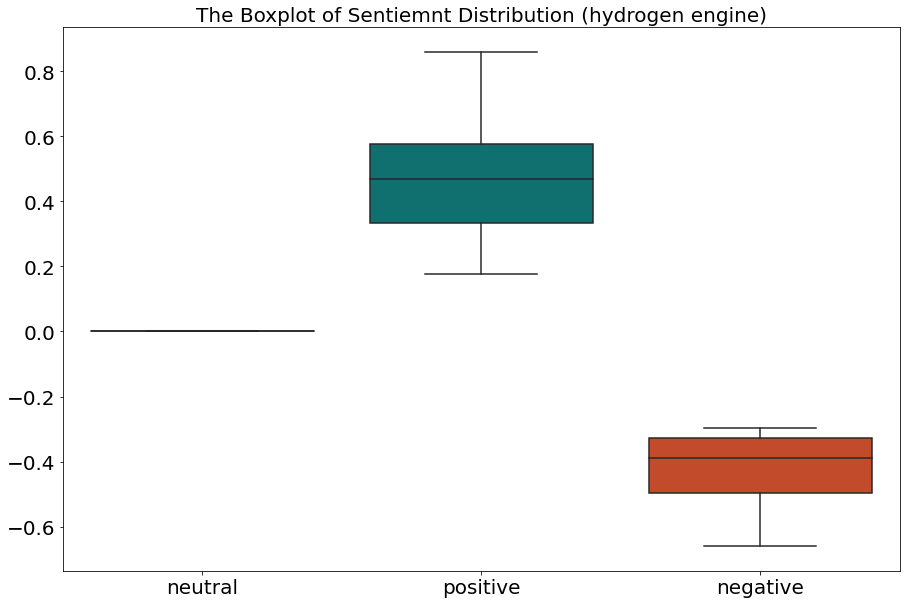

In [51]:
# Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=hydrogen_engine)

plt.title("The Boxplot of Sentiemnt Distribution (hydrogen engine)", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

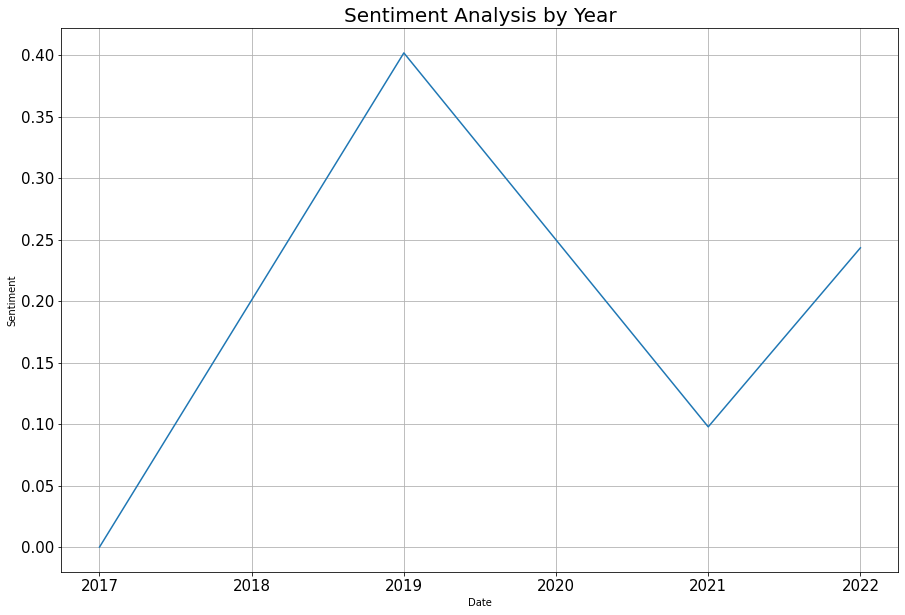

In [52]:
# Lineplot
plt.figure(figsize=(15,10))

plt.plot(hydrogen_engine.groupby(['year'])['compound'].mean())

plt.title("Sentiment Analysis by Year", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

#### natural gas

Text(0, 0.5, '')

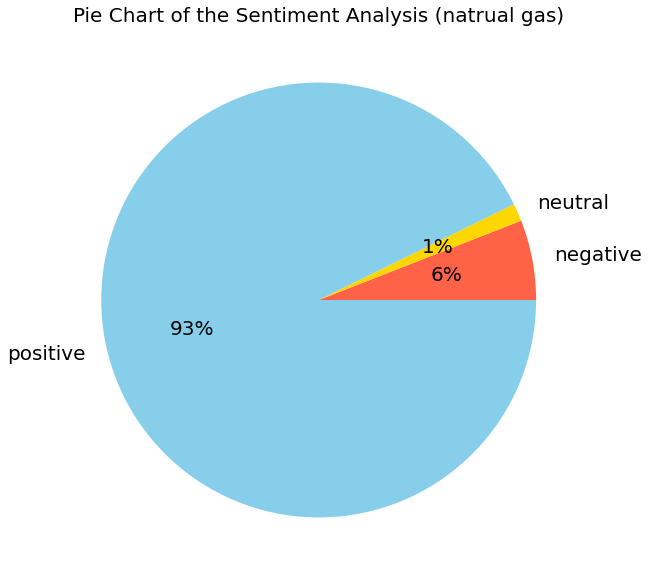

In [53]:
plt.figure(figsize=(15,10))

natural_gas.groupby('sentiment').size().plot(kind='pie', autopct='%1.0f%%', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])

plt.title("Pie Chart of the Sentiment Analysis (natrual gas)", fontsize=20)
plt.xlabel("")
plt.ylabel("")

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

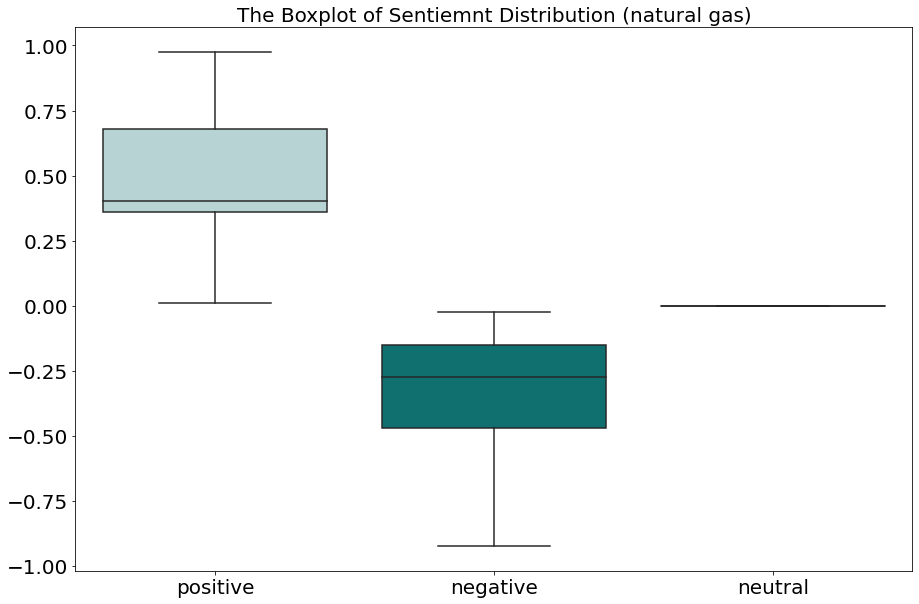

In [54]:
# Boxplot
plt.figure(figsize=(15,10))
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=natural_gas)

plt.title("The Boxplot of Sentiemnt Distribution (natural gas)", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

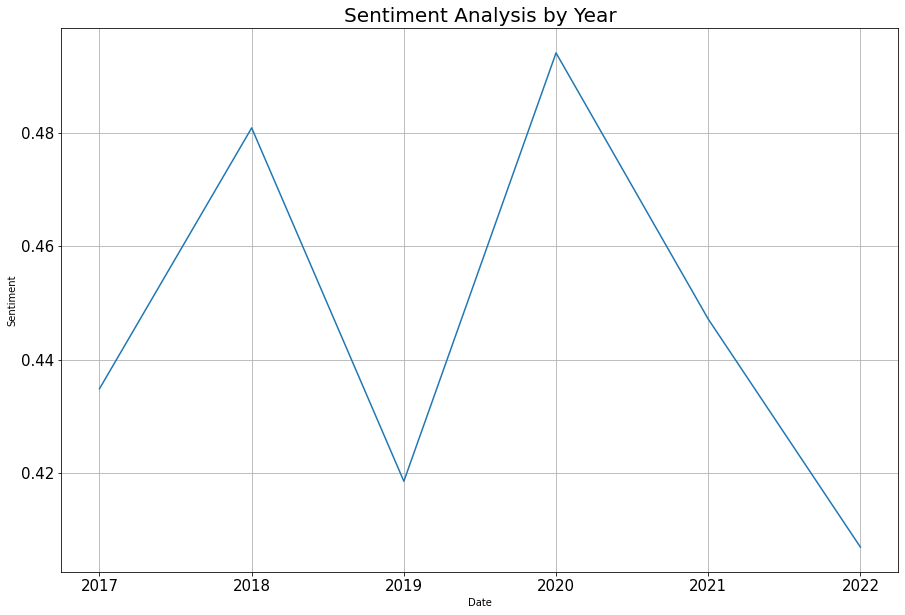

In [55]:
# Lineplot
plt.figure(figsize=(15,10))

plt.plot(natural_gas.groupby(['year'])['compound'].mean())

plt.title("Sentiment Analysis by Year", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

### pandemic

In [56]:
tweets['pandemic'] = np.where(tweets['text_string_fdist'].str.contains('covid|pandemic|covid 19|', case=False, regex=True), True, False)



In [57]:
tweets.pandemic.value_counts()

True    47120
Name: pandemic, dtype: int64

In [58]:
pandemic = tweets[tweets['text_string_fdist'].str.contains('covid|covid 19|pandemic')]
pandemic['pandemic'].value_counts()

True    115
Name: pandemic, dtype: int64

In [59]:
electric

year created_at                                           original  \
4      2017 2017-01-02  Mercedes Benz Style Kids Ride on Battery Power...   
7      2017 2017-01-03  Almost every major automaker now has announced...   
8      2017 2017-01-03  The Renault Zoe, best-selling electric car in ...   
19     2017 2017-01-05  @wggm @jay_21_  It really depends on battery t...   
20     2017 2017-01-05  What do you make of the lack of major battery-...   
...     ...        ...                                                ...   
47114  2022 2022-08-31  DETROIT (AP) — General Motors said Wednesday t...   
47115  2022 2022-08-31  Volvo's campaign promotes its range of Recharg...   
47116  2022 2022-08-31  Volvo Trucks North America declared the end of...   
47118  2022 2022-08-31  One of the added complexities of modern life a...   
47119  2022 2022-08-31  @oilcata @jonandrelokke @BMW @nelhydrogen @H2E...   

                                                  edited  \
4      mercedes benz style kids ride on battery power...   
7      almost every major automaker now has announced...   
8      the renault zoe  best selling electric car in ...   
19        it really depends on battery technology pro...   
20     what do you make of the lack of major battery ...   
...                                                  ...   
47114  detroit  ap    general motors said wednesday t...   
47115  volvo s campaign promotes its range of recharg...   
47116  volvo trucks north america declared the end of...   
47118  one of the added complexities of modern life a...   
47119         mercedes benz cancelled the h2 developm...   

                                 tweet_without_stopwords  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8       renault zoe best selling electric car europe ...   
19      really depends battery technology progress th...   
20      make lack major battery electric vehicles sho...   
...                                                  ...   
47114  detroit ap general motors said wednesday new e...   
47115  volvo campaign promotes range recharge electri...   
47116  volvo trucks north america declared end innova...   
47118  one added complexities modern life forever con...   
47119   mercedes benz cancelled h2 development severa...   

                                              text_token  \
4      [mercedes, benz, style, kids, ride, battery, p...   
7      [almost, every, major, automaker, announced, p...   
8      [renault, zoe, best, selling, electric, car, e...   
19     [really, depends, battery, technology, progres...   
20     [make, lack, major, battery, electric, vehicle...   
...                                                  ...   
47114  [detroit, ap, general, motors, said, wednesday...   
47115  [volvo, campaign, promotes, range, recharge, e...   
47116  [volvo, trucks, north, america, declared, end,...   
47118  [one, added, complexities, modern, life, forev...   
47119  [mercedes, benz, cancelled, h2, development, s...   

                                             text_string  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8      renault zoe best selling electric car europe r...   
19     really depends battery technology progress thi...   
20     make lack major battery electric vehicles show...   
...                                                  ...   
47114  detroit general motors said wednesday new elec...   
47115  volvo campaign promotes range recharge electri...   
47116  volvo trucks north america declared end innova...   
47118  one added complexities modern life forever con...   
47119  mercedes benz cancelled development several ye...   

                                       text_string_fdist  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8      renault zoe

In [60]:
electric_edited = electric.assign(category='elecgtric')
hydrogen_edited = hydrogen.assign(category='hydrogen')
hydrogen_engine_edited = hydrogen_engine.assign(category='hydrogen_engine')
natural_gas_edited = natural_gas.assign(category='natural_gas')

category_df = pd.concat([electric_edited,hydrogen_edited,hydrogen_engine_edited,natural_gas_edited], axis=0)

In [61]:
category_df

year created_at                                           original  \
4      2017 2017-01-02  Mercedes Benz Style Kids Ride on Battery Power...   
7      2017 2017-01-03  Almost every major automaker now has announced...   
8      2017 2017-01-03  The Renault Zoe, best-selling electric car in ...   
19     2017 2017-01-05  @wggm @jay_21_  It really depends on battery t...   
20     2017 2017-01-05  What do you make of the lack of major battery-...   
...     ...        ...                                                ...   
46991  2022 2022-08-29  @JessGotLegs Maybe, but Mack Trucks still use ...   
47016  2022 2022-08-29  @JustSte94403994 @KaylaJinicia @RepTroyNehls P...   
47041  2022 2022-08-30  PSA: When you destroy the oil and natural gas ...   
47048  2022 2022-08-30  @AFP maybe they can increase their oil exports...   
47078  2022 2022-08-30  The Cummins B6.7N natural gas engine available...   

                                                  edited  \
4      mercedes benz style kids ride on battery power...   
7      almost every major automaker now has announced...   
8      the renault zoe  best selling electric car in ...   
19        it really depends on battery technology pro...   
20     what do you make of the lack of major battery ...   
...                                                  ...   
46991   maybe  but mack trucks still use diesel fuel ...   
47016     put gas powered volvo had less problems tha...   
47041  psa  when you destroy the oil and natural gas ...   
47048   maybe they can increase their oil exports  oh...   
47078  the cummins b6 7n natural gas engine available...   

                                 tweet_without_stopwords  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8       renault zoe best selling electric car europe ...   
19      really depends battery technology progress th...   
20      make lack major battery electric vehicles sho...   
...                                                  ...   
46991   maybe mack trucks still use diesel fuel mr se...   
47016   put gas powered volvo less problems gonna get...   
47041  psa destroy oil natural gas industry prices ev...   
47048   maybe increase oil exports oh wait oil well m...   
47078   cummins b6 7n natural gas engine available ne...   

                                              text_token  \
4      [mercedes, benz, style, kids, ride, battery, p...   
7      [almost, every, major, automaker, announced, p...   
8      [renault, zoe, best, selling, electric, car, e...   
19     [really, depends, battery, technology, progres...   
20     [make, lack, major, battery, electric, vehicle...   
...                                                  ...   
46991  [maybe, mack, trucks, still, use, diesel, fuel...   
47016  [put, gas, powered, volvo, less, problems, gon...   
47041  [psa, destroy, oil, natural, gas, industry, pr...   
47048  [maybe, increase, oil, exports, oh, wait, oil,...   
47078  [cummins, b6, 7n, natural, gas, engine, availa...   

                                             text_string  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8      renault zoe best selling electric car europe r...   
19     really depends battery technology progress thi...   
20     make lack major battery electric vehicles show...   
...                                                  ...   
46991  maybe mack trucks still use diesel fuel semi r...   
47016  put gas powered volvo less problems gonna get ...   
47041  psa destroy oil natural gas industry prices ev...   
47048  maybe increase oil exports wait oil well maybe...   
47078  cummins natural gas engine available new peter...   

                                       text_string_fdist  \
4      mercedes benz style kids ride battery powered ...   
7      almost every major automaker announced plans l...   
8      renault zoe

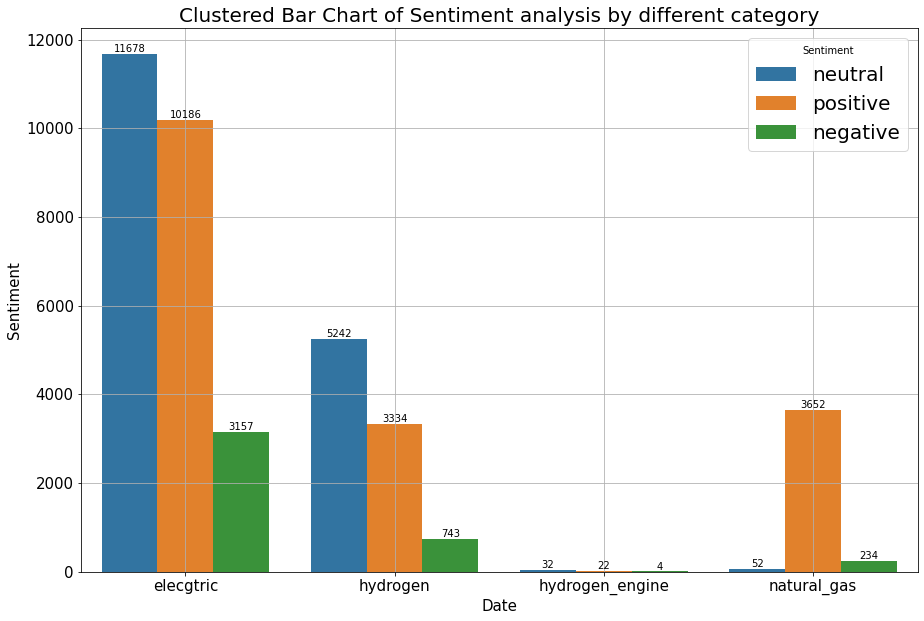

In [62]:
plt.figure(figsize=(15,10))
# ax = category_df.groupby(['category']).sentiment.value_counts().reset_index(name='counts').pivot(index='category', columns='sentiment', values='counts').plot(kind='bar')
# plot and add annotations
p = sns.countplot(data=category_df, x='category', hue='sentiment')
p.legend(title='Sentiment', bbox_to_anchor=(1, 1), fontsize=20)

for c in p.containers:
    # set the bar label
    p.bar_label(c, fmt='%.0f', label_type='edge')
    
plt.title("Clustered Bar Chart of Sentiment analysis by different category", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sentiment", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()